# 2.2 Mixture Modelos y Segmentación de Clientes de Banco 

Al igual que el task anterior, deberá construir un modelo basado en aprendizaje no supervisado para el dataset dado. 
Lo que se busca con este modelo es poder segmentar a clientes de una entidad bancaria para poder así tomar 
decisiones a nivel comercial y potenciar las operaciones de la empresa. Recuerden que: 

● Revisen la breve exploración de datos que hicieron previamente. No es necesario que lo repitan acá dado 
que ya lo hicieron antes y es el mismo dataset. Pero recuerden que: 

○ Deben seleccionar las variables para este modelo (si aplica) 

○ Tengan sus features escaladas 

● Recuerde definir de forma clara y razonada (es decir, diga el por qué de su elección) de una métrica de 
desempeño principal


In [ ]:
#librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture


In [ ]:
#carga de datos
df = pd.read_csv("./bank_transactions.csv")

In [ ]:
#exploracion de datos
#mostrar las columanas
print("\n--Columnas:---")
print(list(df.columns))

#resumen del set de datos
print("\n--Resumen del set de datos:--")
print(df.describe())

In [ ]:
#obtener el tipo de datos
print("\n----Tipo de datos:---")
print(df.dtypes)
tipos_de_datos = df.dtypes.value_counts()
print('resumen:')
print(tipos_de_datos)

### Variables

TransactionID           : id de la transacción

CustomerID              : id del customer

CustomerDOB             : fecha de nacimiento del customer

CustGender              : género del cliente

CustLocation            : ubicacion del cliente

CustAccountBalance      : saldo de la cuenta del cliente

TransactionDate         : fecha de la transacción

TransactionTime         : hora de la transacción

TransactionAmount (INR) : monto de la transacción en rupias indias.


In [ ]:
# Buscando valores nulls
print("- - - - - - - VALORES NULLS - - - - - - -")
nulos = df.isnull()
print(nulos)

nulos_por_columna = df.isnull().sum()
print(list(nulos_por_columna))

In [ ]:
# Elimina filas con al menos un valor nulo
df = df.dropna(axis=0)

In [ ]:
df["CustGender"].value_counts()

In [ ]:
# Quitar T porque solo tiene un valor y es insignificante
df = df[df["CustGender"] != "T"]

# Balancear el dataset
df_majority = df[df["CustGender"] == "M"]
df_minority = df[df["CustGender"] == "F"]

df_majority_sample = df_majority.sample(n=len(df_minority), random_state=42)

df_balanced = pd.concat([df_majority_sample, df_minority])

df_balanced["CustGender"].value_counts()

In [ ]:
# Calcular la edad
df_balanced["CustomerDOB"] = pd.to_datetime(df_balanced["CustomerDOB"], errors="coerce")
current_year = datetime.now().year
df_balanced["Age"] = current_year - df_balanced["CustomerDOB"].dt.year

Objetivo: segmentar a clientes de una entidad bancaria para poder tomar desiciones a nivel comercial y potenciar las operaciones de la empresa.

Seleccionar las variables para el modelo:
- Age
- CustGender
- CustAccountBalance
- Transaction Amount (INR)

variables que podrian servir, pero en este caso no se usaran: 
- CustomerID
- CustLocation
- TransactionDate
- TransactionTime


In [ ]:
# Data para usar
df_data = df_balanced[["Age", "CustAccountBalance", "CustGender", "TransactionAmount (INR)"]].copy()

df_data[["Age", "CustAccountBalance", "TransactionAmount (INR)"]] = df_data[["Age", "CustAccountBalance", "TransactionAmount (INR)"]].astype(float)
scaler = MinMaxScaler()

# Normalizar los datos
df_data.loc[:,["Age", "CustAccountBalance", "TransactionAmount (INR)"]] = scaler.fit_transform(df_data[["Age", "CustAccountBalance", "TransactionAmount (INR)"]])
df_data.loc[:,"CustGender"] = df_data["CustGender"].map({"M": 0, "F": 1})

-------------
## 2.2.1 con liberias

In [ ]:
#saber el numero de K clusters
numeroClusters = range(1,11)
wcss = []

for i in numeroClusters:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_data)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss, marker='o')
plt.xticks(numeroClusters)
plt.xlabel("K clusters")
plt.ylabel("WSS")
plt.title("Gráfico de Codo")
plt.show()

En el grafico del codo, nos indica que k=2 es un buen numero para los datos, ya que la suma de wss disminuye rapidamente hasta los 2 clusters y luego se vuelve gradual.

In [ ]:
#modelo de mixture models para segmentar a los clientes en la cantidad de grupos decidida.
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms


n = 2
#crear y ajustar el modelo de mixture models
gmm = GaussianMixture(n_components=n, random_state=42)
gmm.fit(df_data)

#predecir los clusters para cada punto de datos
df_data["Cluster"] = gmm.predict(df_data)

centroides = gmm.means_
covarianza = gmm.covariances_
# print(covarianza)

#funcion de elipse de  covarianza para los clusters
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_patch(ellip)
    return ellip



In [ ]:
# visualizar los clusters 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='TransactionAmount (INR)', hue='Cluster', data=df_data, palette='viridis')
plt.scatter(centroides[:, 0], centroides[:, 3], c='red', s=300, label='centroides', marker='x')
for i in range(n):
    cov_matrix = covarianza[i][np.ix_([0, 3], [0, 3])]
    centroid_pos = centroides[i, [0, 3]]  # posicion del centroide de 'Age' y 'TransactionAmount (INR)'
    plot_cov_ellipse(cov_matrix, centroid_pos, nstd=2, alpha=0.5, edgecolor='red')
plt.title('clusters de clientes')
plt.xlabel('edad')
plt.ylabel('monto de la transaccion (INR)')
plt.legend()
plt.show()

print(df_data.columns)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='CustAccountBalance', y='TransactionAmount (INR)', hue='Cluster', data=df_data, palette='viridis')
plt.scatter(centroides[:, 1], centroides[:, 3], c='red', s=300, label='Centroides', marker='x')
for i in range(n):
    print(f"Cluster {i}:" )
    cov_matrix = covarianza[i][np.ix_([1, 3], [1, 3])]  # posiciones de CustAccountBalance y TransactionAmount (INR)
    centroid_pos = centroides[i, [1, 3]]  # posicion del centroide de CustAccountBalance y 'TransactionAmount (INR)
    print(cov_matrix)
    print(centroid_pos)
    plot_cov_ellipse(cov_matrix, centroid_pos, nstd=2, alpha=0.8, edgecolor='red')

plt.title('clusters de Clientes')
plt.xlabel('saldo de la cuenta del cliente')
plt.ylabel('monto de la transaccion (INR)')
plt.legend()
plt.show()

En el segundo gráfico se ve como si solo hubiera 1 centroide, pero como se ve en sus datos de cada cluster estan bastante cerca, por lo tanto no se ve el otro centroide.

#### PCA

In [ ]:
from sklearn.decomposition import PCA

#reducir la dimensionalidad a 2D usando PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_data.drop(columns=['Cluster', 'PCA1', 'PCA2']))

#poner los resultados en el df
df_data['PCA1'] = df_pca[:, 0]
df_data['PCA2'] = df_pca[:, 1]

# recalcular los centroieds para pca
centroides_pca = pca.transform(centroides)
# recalcular la covarianza para pca
covarianza_pca = np.array([pca.components_ @ cov @ pca.components_.T for cov in covarianza])


plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_data, palette='viridis')
plt.scatter(centroides_pca[:, 0], centroides_pca[:, 1], s=300, c='red', label='Centroides', marker='X')
for i in range(n):
    cov_matrix = covarianza_pca[i]
    centroid_pos = centroides_pca[i]
    plot_cov_ellipse(cov_matrix, centroid_pos, nstd=2, alpha=0.5, edgecolor='red')
plt.title('Clusters de Clientes con PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()



PCA definitivamente ayudo a mejorar los clusters, notandose la diferencia entre ambos. Esto es porque PCA es un metodo estadistico para transformar las caracteristicas originales de un conjunto de datos a un nuevo conjunto de caracteristicas con componentes principales. Entonces, estos componentes principales son combinaciones lineales de las variables originales y tienen las caracteristicas de: maximizar la varianza y la ortogonalidad. De esta forma, facilitando la vizualización de los datos y identificacion de patrones, clusters y relaciones que no se ve en el espacio original porque tiene una mayor dimension.

Metrica de desempeño

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# muestra de datos
df_sample = df_data.sample(frac=0.1, random_state=42)

#silhouette Score
silhouette_avg = silhouette_score(df_sample.drop(columns=['Cluster']), df_sample['Cluster'])
print(f"Silhouette Score Promedio: {silhouette_avg}")
#silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(df_sample.drop(columns=['Cluster']), df_sample['Cluster'])


fig, ax1 = plt.subplots(figsize=(10, 6))
#rango
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(df_sample) + (n + 1) * 10]) #tamaño

y_lower = 10
for i in range(n):
    ith_cluster_silhouette_values = sample_silhouette_values[df_sample['Cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

ax1.set_title("Gráfico de Silhouette para los clusters")
ax1.set_xlabel("Valores del Silhouette")
ax1.set_ylabel("Cluster")

# linea para ver el promedio
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.show()



Como se puede ver en la gráfica y el resultado del promedio que es cercano a 1, esto nos indica que los puntos estan bien agrupados dentro de sus propios clusters y que están bien separados entre sí.

-------------
## 2.2.1 con liberias

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


In [68]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['CustAccountBalance', 'TransactionAmount (INR)']]
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df


In [69]:

def initialize_parameters(X, k):
    n, d = X.shape
    np.random.seed(42)
    means = X[np.random.choice(n, k, replace=False)]
    covariances = [np.eye(d) for _ in range(k)]
    weights = np.ones(k) / k
    return means, covariances, weights


In [ ]:

def e_step(X, means, covariances, weights):
    k = len(weights)
    responsibilities = np.zeros((X.shape[0], k))
    for i in range(k):
        try:
            responsibilities[:, i] = weights[i] * multivariate_normal.pdf(X, mean=means[i], cov=covariances[i], allow_singular=True)
        except Exception as e:
            print(f"Error en la distribución normal multivariada: {e}")
            print(f"Covarianza del cluster {i}:\n{covariances[i]}")
    responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
    responsibilities_sum[responsibilities_sum == 0] = 1e-6 
    responsibilities /= responsibilities_sum
    return responsibilities


In [ ]:

def m_step(X, responsibilities):
    k = responsibilities.shape[1]
    n, d = X.shape
    Nk = responsibilities.sum(axis=0)
    means = np.dot(responsibilities.T, X) / Nk[:, None]
    covariances = []
    for i in range(k):
        diff = X - means[i]
        cov = np.dot(responsibilities[:, i] * diff.T, diff) / Nk[i]
        cov += np.eye(d) * 1e-6
        covariances.append(cov)
    weights = Nk / n
    return means, covariances, weights


In [72]:

def gmm(X, k, max_iters=50, tol=1e-4, verbose=True):
    means, covariances, weights = initialize_parameters(X, k)
    for iteration in range(max_iters):
        if verbose:
            print(f"Iteración {iteration+1}/{max_iters}")
        responsibilities = e_step(X, means, covariances, weights)
        new_means, new_covariances, new_weights = m_step(X, responsibilities)
        if np.linalg.norm(new_means - means) < tol:
            if verbose:
                print("Convergencia alcanzada.")
            break
        means, covariances, weights = new_means, new_covariances, new_weights
    return means, covariances, weights, responsibilities

In [73]:

def plot_clusters(X, responsibilities, means, covariances, k):
    colors = ['r', 'g', 'b', 'y', 'c']
    labels = np.argmax(responsibilities, axis=1)
    plt.figure(figsize=(8, 6))
    for i in range(k):
        cluster_points = X[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=15, color=colors[i], alpha=0.5, label=f'Cluster {i}')
        eigvals, eigvecs = np.linalg.eigh(covariances[i])
        theta = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        ell = plt.matplotlib.patches.Ellipse(means[i], 2*np.sqrt(eigvals[0]), 2*np.sqrt(eigvals[1]), angle=theta, edgecolor=colors[i], facecolor='none')
        plt.gca().add_patch(ell)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.title('Clusters con GMM')
    plt.show()



Iteración 1/50
Iteración 2/50
Iteración 3/50
Iteración 4/50
Iteración 5/50
Iteración 6/50
Iteración 7/50
Iteración 8/50
Iteración 9/50
Iteración 10/50
Iteración 11/50
Iteración 12/50
Iteración 13/50
Iteración 14/50
Iteración 15/50
Iteración 16/50
Iteración 17/50
Iteración 18/50
Iteración 19/50
Iteración 20/50
Iteración 21/50
Iteración 22/50
Iteración 23/50
Iteración 24/50
Iteración 25/50
Iteración 26/50
Iteración 27/50
Iteración 28/50
Iteración 29/50
Iteración 30/50
Iteración 31/50
Iteración 32/50
Iteración 33/50
Iteración 34/50
Iteración 35/50
Iteración 36/50
Iteración 37/50
Iteración 38/50
Iteración 39/50
Iteración 40/50
Iteración 41/50
Iteración 42/50
Iteración 43/50
Iteración 44/50
Iteración 45/50
Iteración 46/50
Iteración 47/50
Iteración 48/50
Iteración 49/50
Iteración 50/50
Silhouette Score: 0.3860


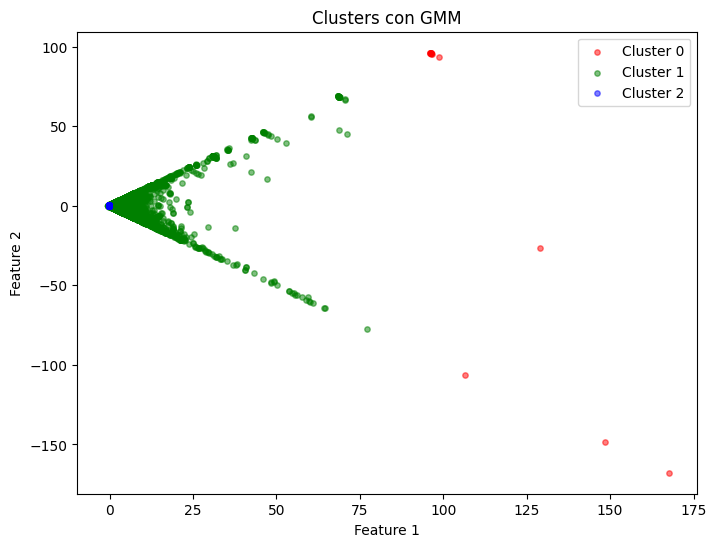

In [74]:


df = load_data('bank_transactions.csv')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values)

if np.isnan(X_scaled).any():
    raise ValueError("Datos contienen NaN después del escalado.")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

if np.isnan(X_pca).any():
    raise ValueError("Datos contienen NaN después de PCA.")

k = 3
means, covariances, weights, responsibilities = gmm(X_pca, k, verbose=True)

sample_size = min(5000, len(X_pca))
labels = np.argmax(responsibilities, axis=1)
silhouette = silhouette_score(X_pca, labels, sample_size=sample_size)
print(f'Silhouette Score: {silhouette:.4f}')

plot_clusters(X_pca, responsibilities, means, covariances, k)


#### ¿Podría PCA ayudarle a mejorar sus clusters? ¿Por qué?

Sí, **PCA puede mejorar los clusters** porque reduce la dimensionalidad manteniendo la mayor variabilidad de los datos, lo que ayuda a eliminar ruido y redundancias. Esto facilita la separación de los grupos y mejora la convergencia del modelo GMM. Además, permite una mejor visualización en 2D y puede mejorar la calidad del clustering, reflejado en métricas como el **Silhouette Score**.

#### Muestre al menos una gráfica que muestre cómo se dividen los clusters seleccionados
 * Seleccione dos features, justifique su elección

Para visualizar la división de los clusters, generamos una gráfica utilizando **PCA** para reducir la dimensionalidad a dos componentes principales, que capturan la mayor variabilidad del dataset. Elegimos estas dos features transformadas porque permiten una mejor separación visual de los clusters sin depender de combinaciones arbitrarias de variables originales. La gráfica muestra los puntos de datos coloreados según sus clusters y las elipses de covarianza para representar la distribución gaussiana de cada grupo, facilitando la interpretación del modelo GMM.

#### Provea una métrica de desempeño, justificando su elección


Para evaluar el desempeño del clustering, utilizamos el **Silhouette Score**, una métrica que mide la separación y cohesión de los clusters. Esta métrica fue elegida porque permite evaluar qué tan bien están agrupados los puntos sin necesidad de etiquetas, algo esencial en problemas de aprendizaje no supervisado.